All assignments need to be submitted via github classroom:
https://classroom.github.com/g/yCXet19l
and as PDF via gradescope.


The goal of this taks is to provide a realistic setting for a machine learning task.
Therefore instructions will not specify the exact steps to carry out. Instead, it is part of the
assignment to identify promising features, models and preprocessing methods and apply them
as appropriate.

## Task 1: Identify Features

Assemble a dataset consisting of features and target (for example in a dataframe or in two
arrays X and y). What features are relevant for the prediction task?
Are there any features that should be excluded because they leak the target information?
Show visualizations or statistics to support your selection.
You are not required to use the description column, but you can try to come up with relevant
features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later
in the class.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso,LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score


# to disregard warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('vehicles.csv')

In [3]:
df.head(3)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884


In [4]:
n_rows = df.shape[0]
print("number of rows: ",n_rows )
print("")
print("counts and percentage of value counts of the columns")

for i in range(len(df.columns)):
    col = df.columns[i]
    unique_val_counts = len(df[col].value_counts())
    print(col, unique_val_counts, "  ",round(unique_val_counts/n_rows*100,2), "%")

number of rows:  509577

counts and percentage of value counts of the columns
id 509577    100.0 %
url 509577    100.0 %
region 403    0.08 %
region_url 413    0.08 %
price 17854    3.5 %
year 114    0.02 %
manufacturer 43    0.01 %
model 35852    7.04 %
condition 6    0.0 %
cylinders 8    0.0 %
fuel 5    0.0 %
odometer 119873    23.52 %
title_status 6    0.0 %
transmission 3    0.0 %
vin 180145    35.35 %
drive 3    0.0 %
size 4    0.0 %
type 13    0.0 %
paint_color 12    0.0 %
image_url 349468    68.58 %
description 427803    83.95 %
county 0    0.0 %
state 51    0.01 %
lat 51488    10.1 %
long 51467    10.1 %


#### Irrelevant features for prediction tasks:
The feature **'county'** is irrelevant feature as noted on the Kaggle data description page (i.e. "useless column left in by mistake"). Also, **'region_url'** seems repetetive of the feature 'region' and does not provide much useful information regarding the target information i.e. the car's price.

Also the feature title_status consists of 95% of "clean" , 2% of "rebuilt", and others (as shown on dataset description),and we beleived this column does not really give meaningful indicator for predicting the car's value and thus removed.

#### Features that should be excldued because they leak target information: 
As shown on the above statistics, 100% of **'id' and 'url'** values are distinct, meaning that a model might just learn to associate id and target output without being able to genearlize (as noted on Piazza).Thus, these two columns are certainly leaking the target information.

Moreover, **'image_url'** (68.58%) and **'description'** (83.95%) features also contain more than half of data of unique values, which thus would likely to leak the target information. Although the vehicle identification number has unique value counts around 35%, since its unique number can be associtated with the car's sale price, **'vin'** should also considered to be a feature that leak the target info

Also, assuming sellers on Craiglists are mostly individuals not companies, **'lat'** and **'long'** features can also thought to be features that leak target infomration, in a similar reasongin to 'id' (i.e. unique latitude and longitude coordinate to associated with a car's selling price.

Thus, irrelevant features: **'county', 'region_url', 'title_status**

features that leak target info: **'id', 'url', 'vin', 'image_url', 'description', 'lat', 'long'**

Looking more specifically for some of the features that would need preprocessing (done in Task3):

count    5.095770e+05
mean     5.479684e+04
std      9.575025e+06
min      0.000000e+00
25%      3.995000e+03
50%      9.377000e+03
75%      1.795500e+04
max      3.600029e+09
Name: price, dtype: float64


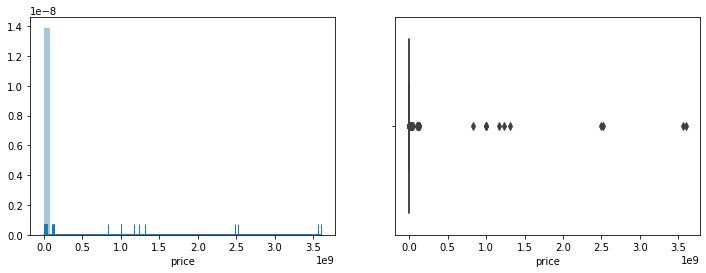

In [5]:
print(df.price.describe());

fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(df.price, rug=True, ax=ax[0]);
sns.boxplot(df.price, ax=ax[1]);

As shown above, it is reasonable to remove data of car's price at 0 and outliers that are higher than majority of the price (will do preprocessing this in Task3)

count    508050.000000
mean       2009.662236
std           8.567953
min        1900.000000
25%        2007.000000
50%        2011.000000
75%        2015.000000
max        2021.000000
Name: year, dtype: float64


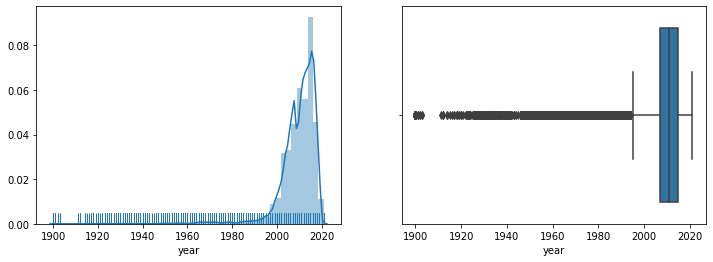

In [6]:
print(df.year.describe());

fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(df.year, rug=True, ax=ax[0]);
sns.boxplot(df.year, ax=ax[1]);

As shown above, since it is unlikely to predict a car's value that is more than 60 years old, it is reasonable to remove data of car's year before 1960 (will do preprocessing this in Task3)

count    4.172530e+05
mean     1.017300e+05
std      1.073790e+05
min      0.000000e+00
25%      4.948800e+04
50%      9.489400e+04
75%      1.387780e+05
max      1.000000e+07
Name: odometer, dtype: float64


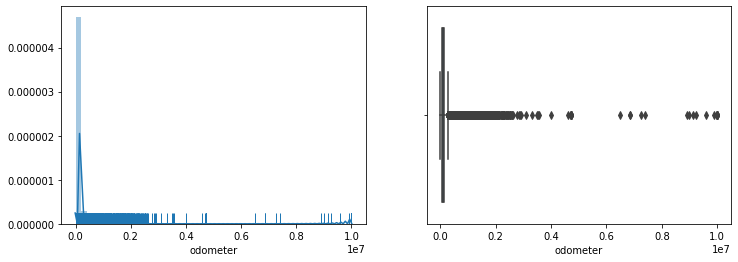

In [7]:
print(df.odometer.describe());

fig,ax = plt.subplots(1,2,figsize=(12,4))
sns.distplot(df.odometer, rug=True, ax=ax[0]);
sns.boxplot(df.odometer, ax=ax[1]);

It seems reasonable to rule out outlier (will do preprocessing in Task3)

## Task 2: Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing
appropriate preprocessing and cross-validating a linear model. Feel free to exclude features or
do simplified preprocessing for this task. As mentioned before, you don’t need to validate the
model on the whole dataset.

In [8]:
# dropping irrelevant and features that leak the target information
df2 = df.drop(['county', 'region_url','title_status', 'id', 'vin', 'url', 'image_url', 'description', 'lat', 'long'], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509577 entries, 0 to 509576
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        509577 non-null  object 
 1   price         509577 non-null  int64  
 2   year          508050 non-null  float64
 3   manufacturer  486813 non-null  object 
 4   model         501588 non-null  object 
 5   condition     277643 non-null  object 
 6   cylinders     309894 non-null  object 
 7   fuel          505592 non-null  object 
 8   odometer      417253 non-null  float64
 9   transmission  505858 non-null  object 
 10  drive         365434 non-null  object 
 11  size          167574 non-null  object 
 12  type          368046 non-null  object 
 13  paint_color   344871 non-null  object 
 14  state         509577 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 58.3+ MB


In [9]:
#Taking sampple of the whole dataset
df2_sample = df2.sample(n=10000, random_state=1)

target_sample = df2_sample.price
X_sample = df2_sample.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, random_state=0)

In [10]:
#Baseline model: Linear regression with 'minimal' preprocessing
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))
cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess = make_column_transformer(
    (cat_preprocessing, make_column_selector(dtype_include='object')),
    remainder=cont_preprocessing)

model = make_pipeline(preprocess, LinearRegression())

scores = cross_val_score(model, X_train, y_train)
print("baseline mean score: ", np.mean(scores))

baseline mean score:  0.0698547768320382


## Task 3: Feature Engineering

Create derived features and perform more in-depth preprocessing and data cleaning. Does this
improve your model? In particular, think about how to encode categorical variables and
whether adding interactions (for example using PolynomialFeatures or manually) might help.

In [11]:
# As mentioend in Task 1, removing outliers for the price, year, odometer columns
df3 = df2.loc[(df2.price > 100) & (df2.price<df2.price.quantile(.99))]
df3 = df3.loc[(df3.year >1960)]
df3 = df3.loc[(df3.odometer < df3.odometer.quantile(.975))]

In [12]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364779 entries, 0 to 509576
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        364779 non-null  object 
 1   price         364779 non-null  int64  
 2   year          364779 non-null  float64
 3   manufacturer  354087 non-null  object 
 4   model         361252 non-null  object 
 5   condition     216774 non-null  object 
 6   cylinders     240846 non-null  object 
 7   fuel          361762 non-null  object 
 8   odometer      364779 non-null  float64
 9   transmission  361773 non-null  object 
 10  drive         289038 non-null  object 
 11  size          129523 non-null  object 
 12  type          294055 non-null  object 
 13  paint_color   274695 non-null  object 
 14  state         364779 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 44.5+ MB


In [13]:
#Taking sample of the whole dataset
df3_sample = df3.sample(n=10000,random_state=1)

target_sample = df3_sample.price
X_sample = df3_sample.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, random_state=0)

# columns for continuous, OHE, Target Enconding preprocess
cont = [ 'year', 'odometer']
cat_OHE = [ 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type', 'paint_color']
cat_TE = ['region', 'manufacturer','model', 'state']

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from category_encoders import TargetEncoder

cat_OHE_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))

cat_TE_preprocessing = make_pipeline(
    TargetEncoder())

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PolynomialFeatures())

preprocess = make_column_transformer(
    (cont_preprocessing, cont),
    (cat_OHE_preprocessing, cat_OHE),
    (cat_TE_preprocessing, cat_TE))

model = make_pipeline(preprocess, LinearRegression())
scores = cross_val_score(model, X_train, y_train)
print("mean score with more preprocessing and data cleaning: ", np.mean(scores))


mean score with more preprocessing and data cleaning:  0.6973630840258712


Yes more in-depth preprocessing and data cleaning definitely increased the mean cross validation score by a lot (here from 0.06 to 0.697)

## Task 4: Any model

Use any regression model we discussed (trees, forests, gradient boosting, SVM) to improve
your result. You can (and probably should) change your preprocessing and feature engineering
to be suitable for the model. You are not required to try all of these models. Tune parameters
as appropriate

It seems XGBoost (with gridsearch) shows the best score, which is presented at last

In [15]:
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

In [16]:
#Linear SVM Regression - does not seem to work well
model_SVM_R = make_pipeline(preprocess, LinearSVR())
param_grid = {'linearsvr__C': np.logspace(-3, 3, 4)}
grid = GridSearchCV(model_SVM_R, param_grid, cv=6)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.22138361961888708

In [17]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

tree_pipe = make_pipeline(preprocess, DecisionTreeRegressor())

print("tree mean cv score :", np.mean(cross_val_score(tree_pipe, X_train, y_train)))
tree_pipe.fit(X_train,y_train)
print('test score: ',tree_pipe.score(X_test, y_test))

tree mean cv score : 0.5030583888325311
test score:  0.5321478530806133


In [18]:
# Random Forest with Warm start
train_scores = []
test_scores = []

estimator_range = range(1, 35, 10)
for n_estimators in estimator_range:
    model_rf = make_pipeline(preprocess, RandomForestRegressor(n_estimators=n_estimators))
    model_rf.fit(X_train, y_train)
    train_scores.append(model_rf.score(X_train, y_train))
    test_scores.append(model_rf.score(X_test, y_test))
print("best test score (estimators):", max(test_scores))

# Random Forest with grid-search on max_features
#-------------------------------------------------------
# Note: already ran gridsearch over 
# 'randomforestregressor__max_features':  ['auto', 'log2', 'sqrt']
# and found 'auto' to give the best ressult, with
# best score, and test score of _____ respectively. 
# However, since it took a long time, and because we got 
# better score from XGB regressor, as shown below,
# the codes below are commented out
#-------------------------------------------------------

# rf = make_pipeline(preprocess, RandomForestRegressor())
# rf_grid = {'randomforestregressor__max_features':  ['auto', 'log2', 'sqrt']}
# grid_rf = GridSearchCV(rf, rf_grid)
# grid_rf.fit(X_train, y_train)

# print("Grid search of max features")
# print("The best parameter found is: ", grid_rf.best_params_)
# print("Best score: {:.3f}".format(grid_rf.best_score_))
# print("test score: {:.3f}".format(grid_rf.score(X_test, y_test)))

print("")
print("The best parameter found is:", " {'randomforestregressor__max_features': 'auto'}")
print("Best score: 0.782 ")
print("test score: 0.797 ")

best test score (estimators): 0.742279907969622

The best parameter found is:  {'randomforestregressor__max_features': 'auto'}
Best score: 0.782 
test score: 0.797 


In [19]:
# Gradient Boosting
from xgboost import XGBRegressor
xgb = make_pipeline(preprocess, XGBRegressor(warm_start = True, silent=True))

print("XGBoost regressor mean cv score :", np.mean(cross_val_score(xgb, X_train, y_train, cv = 7)))
xgb.fit(X_train,y_train)
print('test score: ',xgb.score(X_test, y_test))

#XGBoost Grid Search
#------------------------------------------------------
#Note: Similar to the random forest shown above, already ran the following
# gridsearch and found the best parameters of 
# gamma = 0.3, learning_rate = 0.2, max_depth = 6. 
# However, since it takes a long time, it was commented out
#-------------------------------------------------------

# xgbregressor__gamma = [0.3, 0.6, 0.9 ]
# xgbregressor__learning_rate = [0.20, 0.40, 0.6, 0.8]
# xgbregressor__max_depth = [2, 4, 6, 8, 10]

# grid_param_xgbregressor = dict(xgbregressor__gamma = xgbregressor__gamma,
#                               xgbregressor__learning_rate = xgbregressor__learning_rate,
#                               xgbregressor__max_depth = xgbregressor__max_depth)

# grid_xgbregressor = GridSearchCV(xgb, grid_param_xgbregressor)
# grid_xgbregressor.fit(X_train, y_train);

# print("XGBoost regressor girdsearch")
# print("The best parameter found is: ", grid_xgbregressor.best_params_)
# print("Best score: {:.3f}".format(grid_xgbregressor.best_score_))
# print("test score: {:.3f}".format(grid_xgbregressor.score(X_test, y_test)))

xgb4 = make_pipeline(preprocess, # i.e. use best parameter values got above
                     XGBRegressor(gamma = 0.3, learning_rate = 0.2, max_depth = 6, 
                                  warm_start = True, silent=True))
xgb4.fit(X_train,y_train)
print("")
print('XGBoost best param test score: ',xgb4.score(X_test, y_test))

XGBoost regressor mean cv score : 0.7477032509135891
test score:  0.7452853446040177

XGBoost best param test score:  0.7718052090374274


**XGBoost** seems to give the best results out of other regression models. Accordingly, we would work on this model for the following questions (with the best parameter setting).

## Task 5: Feature Selections

Identify features that are important for your best model. Which features are most influential,
and which features could be removed without decrease in performance? Does removing
irrelevant features make your model better? (This will be discussed in the lecture on 03/04).

In [20]:
# Taking larger sample of the whole dataset 
# (since we found the best parameter setting)
df5_sample = df3.sample(n=30000,random_state=1)

target_sample = df5_sample.price
X_sample = df5_sample.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_sample, target_sample, random_state=0)

xgb5 = make_pipeline(preprocess, # i.e. use best parameter values got on task4
                     XGBRegressor(gamma = 0.3, learning_rate = 0.2, max_depth = 6, 
                                  warm_start = True, silent=True))
xgb5.fit(X_train,y_train)
print('XGBoost best param test score: ',xgb5.score(X_test, y_test))

XGBoost best param test score:  0.819693290497663


In [21]:
# Preprocessing without polyonomial features
cat_OHE_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))

cat_TE_preprocessing = make_pipeline(
    TargetEncoder())

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess_wo_poly = make_column_transformer(
    (cont_preprocessing, cont),
    (cat_OHE_preprocessing, cat_OHE),
    (cat_TE_preprocessing, cat_TE))

xgb5 = make_pipeline(preprocess_wo_poly, 
                     XGBRegressor(gamma = 0.3, learning_rate = 0.2, max_depth = 6, 
                                  warm_start = True, silent=True))
xgb5.fit(X_train,y_train);

In [22]:
# OHE, Target Encoding, continuous columns
cat_OHE_cols = xgb5['columntransformer'].transformers_[1][1]['onehotencoder'].get_feature_names(cat_OHE)
cat_TE_cols = xgb5['columntransformer'].transformers_[2][1]['targetencoder'].cols
cols =  [ 'year', 'odometer']+ list(cat_OHE_cols) + list(cat_TE_cols)

xgb5.steps[1][1].feature_importances_
xgb5.steps[1][1].get_booster().get_fscore()

feature_importance = list(sorted(zip(map(lambda x: round(x, 3), 
                    xgb5.steps[1][1].feature_importances_), cols), 
                     reverse=True))
feature_plot = pd.DataFrame(feature_importance)
top_15_XGB =feature_plot[:20]
top_15_XGB

,0,1
0,0.132,fuel_diesel
1,0.122,year
2,0.105,model
3,0.069,drive_4wd
4,0.059,drive_fwd
5,0.040,cylinders_4 cylinders
6,0.034,cylinders_8 cylinders
7,0.030,fuel_gas
8,0.027,condition_good
9,0.023,odometer


Since it is quite uninterpretable whether one-hot encoded categorical variable is important (i.e. whether fuel is the most important feature or the specific fuel_diesel type is most important), we would first get the features in order or ranking of "untransformed" features (in this case, it seems undeniable that the features **year, model, odometer** are positioned to be one of the most important features.  For the remaining columns, we would try to target encode all the categorical variables as shown below to see rankings below these.

In [23]:
# To test what would happen if we all do target encoder on categorical variables
cat = cat_OHE + cat_TE

# Preprocessing without polyonomial features
cat_preprocessing = make_pipeline(
    TargetEncoder())

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler())

preprocess_wo_poly_comb = make_column_transformer(
    (cont_preprocessing, cont),
    (cat_preprocessing, cat))

xgb5 = make_pipeline(preprocess_wo_poly_comb, 
                     XGBRegressor(gamma = 0.3, learning_rate = 0.2, max_depth = 6, 
                                  warm_start = True, silent=True))
xgb5.fit(X_train,y_train);

cat_cols = xgb5['columntransformer'].transformers_[1][1]['targetencoder'].cols
cols =  [ 'year', 'odometer']+ cat

xgb5.steps[1][1].feature_importances_
xgb5.steps[1][1].get_booster().get_fscore()

feature_importance = list(sorted(zip(map(lambda x: round(x, 3), xgb5.steps[1][1].feature_importances_), cols), 
              reverse=True))
feature_plot_XGB_TE = pd.DataFrame(feature_importance)
feature_plot_XGB_TE

,0,1
0,0.279,year
1,0.206,model
2,0.160,fuel
3,0.102,drive
4,0.056,cylinders
5,0.045,odometer
6,0.036,condition
7,0.030,type
8,0.025,manufacturer
9,0.016,region


Thus, next successive important features after year, model, odometer, manufacturer (using XGBregressor) shows to be be fuel, drive, cylinders, condition, type, transmission.

It seems consistent that top 3 most important features are **year, model, odometer**, and so on. Following code also look at rankings got from RFE method and mutual information method.

In [24]:
# RFE method

from sklearn.feature_selection import RFE

#Target Encode all categorical features 
cat = ['condition', 'cylinders', 'fuel', 'drive', 'paint_color', 
           'state', 'transmission','type', 'region','model', 'manufacturer']
cont = ['odometer', 'year']

te = TargetEncoder(cols = cat)
X_train_cat = te.fit_transform(X_train[cat],y_train)

cont_preprocessing = make_pipeline(
    SimpleImputer(strategy = 'mean'),
    StandardScaler()
    )
preprocess_rfe = make_column_transformer(
    (cont_preprocessing, cont)
    )

X_train_cont = preprocess_rfe.fit_transform(X_train)
X_train_cont = pd.DataFrame(X_train_cont, columns = cont)
X_train_cont = X_train_cont.set_index(X_train_cat.index)

X_train_preprocess = pd.concat([X_train_cont, X_train_cat], axis = 1)

rfe = RFE(LinearRegression(), n_features_to_select=1)
rfe.fit(X_train_preprocess, y_train)

rfe_col =pd.Series(list((X_train_preprocess.columns)))
rfe_rank = pd.concat([rfe_col, pd.Series(rfe.ranking_)], axis = 1)
rfe_rank.columns = ['feature','RFE_rank']
rfe_result = rfe_rank.sort_values(by=['RFE_rank'])
rfe_result

,feature,RFE_rank
0,odometer,1
1,year,2
11,model,3
4,fuel,4
5,drive,5
10,region,6
3,cylinders,7
8,transmission,8
2,condition,9
9,type,10


In [25]:
# Mutual Information

from sklearn.feature_selection import mutual_info_regression

scores = mutual_info_regression(X_train_preprocess, y_train)

mif_col =pd.Series(list((X_train_preprocess.columns)))
mif_rank = pd.concat([rfe_col, pd.Series(scores)], axis = 1)
mif_rank.columns = ['feature','mutual_info_regression_score']
mif_result = mif_rank.sort_values(by=['mutual_info_regression_score'],ascending = False)
mif_result

,feature,mutual_info_regression_score
11,model,0.426226
1,year,0.379172
0,odometer,0.302955
2,condition,0.160600
9,type,0.156466
12,manufacturer,0.132846
7,state,0.129199
10,region,0.121944
5,drive,0.098573
3,cylinders,0.085328


Comparing rankings got from XGBregressor, RFE, mutual information methods, the successive 5 most important features besides year, model, odometer are fuel, drive, cylinders, type, and condition

In [26]:
# features importance in decreasing top 8 ranking
top_8 = ['year','model','odometer','fuel', 'drive','cylinders', 'condition','type']

cont = ['year', 'odometer']
cat_OHE = [ 'cylinders', 'fuel', 'condition', 'drive', 'type']
cat_TE = ['model']

cat_OHE_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))

cat_TE_preprocessing = make_pipeline(
    TargetEncoder())

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PolynomialFeatures())

preprocess = make_column_transformer(
    (cont_preprocessing, cont),
    (cat_OHE_preprocessing, cat_OHE),
    (cat_TE_preprocessing, cat_TE))

xgb5 = make_pipeline(preprocess, 
                     XGBRegressor(gamma = 0.3, learning_rate = 0.2, max_depth = 6, 
                                  warm_start = True, silent=True))
xgb5.fit(X_train,y_train);
print('XGB test score with 8 selected features: ',xgb5.score(X_test, y_test))
print('XGB test score with whole set of features: ',xgb4.score(X_test, y_test))


XGB test score with 8 selected features:  0.8053778795381846
XGB test score with whole set of features:  0.7856768885844863


Thus, although the model with 8 selected features ( **'year','model','odometer','fuel', 'drive','cylinders', 'condition','type'**) result in slightly lower test result, considering it consists of nearly half of original number of columns, this still remains to be a good, reasonable model

## Task 6: An explainable model

Can you create an “explainable” model that is nearly as good as your best model?
An explainable model should be small enough to be easily inspected - say a linear model with
few enough coefficients that you can reasonably look at all of them, or a tree with a small
number of leaves etc.

In [27]:
# Simple understandable, lienar regression model with 8 selected features
model_LR_8 = make_pipeline(preprocess, LinearRegression())
scores = cross_val_score(model_LR_8, X_train, y_train)
print("lineaer regression mean score with 8 selected features: ", np.mean(scores))

# Selected 5 features
cont = ['year', 'odometer']
cat_OHE = [ 'fuel', 'drive']
cat_TE = ['model']

cat_OHE_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))

cat_TE_preprocessing = make_pipeline(
    TargetEncoder())

cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PolynomialFeatures())

preprocess = make_column_transformer(
    (cont_preprocessing, cont),
    (cat_OHE_preprocessing, cat_OHE),
    (cat_TE_preprocessing, cat_TE))

model_LR_5 = make_pipeline(preprocess, LinearRegression())
scores = cross_val_score(model_LR_5, X_train, y_train)
print("lineaer regression mean score with 5 selected features: ", np.mean(scores))

lineaer regression mean score with 8 selected features:  0.7080358151009362
lineaer regression mean score with 5 selected features:  0.6774049551514569


In [28]:
X_col_wo_TE = ['year', 'odometer', 'fuel', 'drive']
cont = ['year', 'odometer']
cat_OHE = [ 'fuel', 'drive']
cat_TE = ['model']

te = TargetEncoder(cols = cat_TE)
X_train_cat_TE = te.fit_transform(X_train[cat_TE],y_train)
X_train_cat_TE = StandardScaler().fit_transform(X_train_cat_TE)
X_train_cat_TE = pd.DataFrame(X_train_cat_TE, columns = cat_TE)


cat_OHE_preprocessing = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='NA'),
    OneHotEncoder(handle_unknown='ignore'))
X_train_cat_OHE = SimpleImputer(strategy='constant', fill_value='NA').fit_transform(X_train[cat_OHE])
ohe = OneHotEncoder().fit(X_train_cat_OHE)
X_train_cat_OHE = ohe.transform(X_train_cat_OHE).toarray()
X_train_cat_OHE = pd.DataFrame(X_train_cat_OHE, columns = ohe.get_feature_names())
X_train_cat_OHE = X_train_cat_OHE.set_index(X_train_cat_TE.index)


cont_preprocessing = make_pipeline(
    SimpleImputer(),
    StandardScaler(),
    PolynomialFeatures())

preprocess = make_column_transformer(
    (cont_preprocessing, cont)
    )

cont_column = ['1','year','odometer','year_squared','year*odometer','odometer_squared']
X_train_cont = preprocess.fit_transform(X_train)
X_train_cont = pd.DataFrame(X_train_cont, columns = cont_column)
X_train_cont = X_train_cont.set_index(X_train_cat_TE.index)
X_train_preprocess = pd.concat([X_train_cont, X_train_cat_OHE, X_train_cat_TE], axis = 1)
ols = LinearRegression().fit(X_train_preprocess, y_train)


col = pd.Series(list(X_train_preprocess.columns))
ols_coef = pd.concat([col, pd.Series(ols.coef_),pd.Series(abs(ols.coef_))], axis = 1)
ols_coef.columns = ['feature','LR coef', 'abs of LR coef']
ols_coef = ols_coef.sort_values(by=['abs of LR coef'], ascending = False)
ols_coef

,feature,LR coef,abs of LR coef
7,x0_diesel,6173.618062,6173.618062
1,year,4835.277942,4835.277942
8,x0_electric,-3727.293648,3727.293648
16,model,3634.160392,3634.160392
2,odometer,-2484.294104,2484.294104
14,x1_fwd,-2254.218411,2254.218411
12,x1_4wd,2197.456871,2197.456871
9,x0_gas,-1630.655665,1630.655665
3,year_squared,890.733845,890.733845
10,x0_hybrid,-715.631225,715.631225


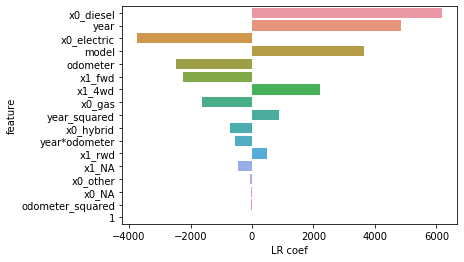

In [29]:
sns.barplot (y='feature',x=  'LR coef', data =ols_coef, orient = 'h')

For the expalinable model, we have choosed the linear regression with selected features from the task5. We have selected top 5 features, which are 'year', 'odometer', 'fuel', 'drive', and 'model'. The mean cv score of the linear regression is around 0.677. As one can see from the above graph, the year, model, and odometer are ranked on the top section. The higher year, meaning newer car, has a positive effect on the price, whereas the lower odometer has a negative effect on the price (clearly as more of the car has been used, its price should be lower. Moreover, different model has a great impact on the price as well. 
For the drive mode, four wheel drive and a rear wheel drive has a positive effect on the price whereas the forward wheel drive has a negative impact on the price, which might indicate people's preference on the drive. For the fuel, only diesel fuel car has a positive impact on the price, which might be caused by scarcity of the diesel cars. 